In [59]:
from __future__ import unicode_literals, print_function

import plac
import random
import warnings
from pathlib import Path
import spacy
from spacy.util import minibatch, compounding
from collections import defaultdict
import operator
import string
from itertools import permutations

In [2]:
def get_entities_for_text(model=None, text=""):
    doc = model(text)
    print("Entities in '%s'" % text)
    entities = {}
    for ent in doc.ents:
        entities[ent.text] = ent.label_
    return entities

def get_scores_per_entity(model=None, texts=[],):
    # Number of alternate analyses to consider. More is slower, and not necessarily better -- you need to experiment on your problem.
    beam_width = 16
    # This clips solutions at each step. We multiply the score of the top-ranked action by this value, and use the result as a threshold. This prevents the parser from exploring options that look very unlikely, saving a bit of efficiency. Accuracy may also improve, because we've trained on greedy objective.
    beam_density = 0.0001 

    docs = list(nlp.pipe(texts, disable=['ner']))
    beams = nlp.entity.beam_parse(docs, beam_width=beam_width, beam_density=beam_density)

    for doc, beam in zip(docs, beams):
        entity_scores = defaultdict(float)
        for score, ents in nlp.entity.moves.get_beam_parses(beam):
            for start, end, label in ents:
                entity_scores[(start, end, label)] += score
        print(doc)
        print(entity_scores)

In [3]:
nlp = spacy.load('en_core_web_sm')

In [4]:
texts = ["Rana's zipcode is 2145"]
doc = nlp(texts[0])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)

Rana PERSON
2145 DATE


In [5]:
# Number of alternate analyses to consider. More is slower, and not necessarily better -- you need to experiment on your problem.
beam_width = 16
# This clips solutions at each step. We multiply the score of the top-ranked action by this value, and use the result as a threshold. This prevents the parser from exploring options that look very unlikely, saving a bit of efficiency. Accuracy may also improve, because we've trained on greedy objective.
beam_density = 0.0001 

docs = list(nlp.pipe(texts, disable=['ner']))
beams = nlp.entity.beam_parse(docs, beam_width=beam_width, beam_density=beam_density)

for doc, beam in zip(docs, beams):
    entity_scores = defaultdict(float)
    for score, ents in nlp.entity.moves.get_beam_parses(beam):
        for start, end, label in ents:
            entity_scores[(start, end, label)] += score
    print(doc)
    print(entity_scores)

Rana's zipcode is 2145
defaultdict(<class 'float'>, {(0, 1, 'PERSON'): 0.6151907254266652, (4, 5, 'DATE'): 0.8081652223579491, (0, 1, 'ORG'): 0.3822024400757443, (4, 5, 'CARDINAL'): 0.16996018814183705, (2, 3, 'DATE'): 0.01752146575251159, (4, 5, 'QUANTITY'): 0.008253334919463753, (0, 1, 'GPE'): 0.002606834497590878, (2, 3, 'PERSON'): 0.003342970599108417, (4, 5, 'TIME'): 0.0014949703526520063})


In [6]:
# new entity label
LABEL_ZIP_CODE = "AU_POST_CODE"

LABEL_PASSWORD = "PASSWORD"

In [44]:
TRAIN_DATA = []

for i in range(0,100):
    #TRAIN_DATA.append(("Rana's zipcode is 2145", {'entities': [(0, 4, 'PERSON'),(18, 22, LABEL_ZIP_CODE)]}))
    TRAIN_DATA.append(("Rana's password is qwertyui", {'entities': [(0, 4, 'PERSON'),(19, 27, LABEL_PASSWORD)]}))

In [45]:
def update_model(model=None, new_model_name="new_model", output_dir=None, n_iter=30):
    """Set up the pipeline and entity recognizer, and train the new entity."""
    random.seed(0)
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    # Add entity recognizer to model if it's not in the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner)
    # otherwise, get it, so we can add labels to it
    else:
        ner = nlp.get_pipe("ner")

    # add new entity label to entity recognizer
    #ner.add_label(LABEL_ZIP_CODE)
    ner.add_label(LABEL_PASSWORD)
    
    if model is None:
        optimizer = nlp.begin_training()
    else:
        optimizer = nlp.resume_training()
    move_names = list(ner.move_names)
    # get names of other pipes to disable them during training
    pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
    # only train NER
    with nlp.disable_pipes(*other_pipes), warnings.catch_warnings():
        # show warnings for misaligned entity spans once
        warnings.filterwarnings("once", category=UserWarning, module='spacy')

        sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        for itn in range(n_iter):
            random.shuffle(TRAIN_DATA)
            batches = minibatch(TRAIN_DATA, size=sizes)
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.4, losses=losses)
                
            print("Losses", losses)

    # test the trained model
#     test_text = "Rana's zipcode is 2145"
#     doc = nlp(test_text)
#     print("Entities in '%s'" % test_text)
#     for ent in doc.ents:
#         print(ent.label_, ent.text)
        
    # test the trained model
    test_text = "Rana's password is 1234qwerty"
    doc = nlp(test_text)
    print("Entities in '%s'" % test_text)
    for ent in doc.ents:
        print(ent.label_, ent.text)

    # save model to output directory
    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.meta["name"] = new_model_name  # rename model
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        # Check the classes have loaded back consistently
        assert nlp2.get_pipe("ner").move_names == move_names
        doc2 = nlp2(test_text)
        for ent in doc2.ents:
            print(ent.label_, ent.text)

In [46]:
update_model(model='en_core_web_sm', new_model_name='en_core_web_sm_updated', output_dir='en_core_web_sm_updated')

Loaded model 'en_core_web_sm'
Losses {'ner': 371.80443118413007}
Losses {'ner': 321.0172429376428}
Losses {'ner': 278.5634756410871}
Losses {'ner': 306.68327444109116}
Losses {'ner': 308.16326928847593}
Losses {'ner': 345.3829082428935}
Losses {'ner': 297.6191637955576}
Losses {'ner': 317.33574399763035}
Losses {'ner': 331.40556792299856}
Losses {'ner': 314.71202162521536}
Losses {'ner': 304.8669029090069}
Losses {'ner': 300.73552921458304}
Losses {'ner': 297.22630242689826}
Losses {'ner': 302.9666694018701}
Losses {'ner': 303.48577321632354}
Losses {'ner': 309.61487365551056}
Losses {'ner': 282.27744101030294}
Losses {'ner': 302.8221065908936}
Losses {'ner': 310.8984657888515}
Losses {'ner': 298.5869388974951}
Losses {'ner': 301.1363290532037}
Losses {'ner': 290.2302663211621}
Losses {'ner': 301.83082052620307}
Losses {'ner': 275.12729308245}
Losses {'ner': 274.2553805517788}
Losses {'ner': 306.17298679586605}
Losses {'ner': 285.3967938702382}
Losses {'ner': 275.1835272018633}
Losses 

In [47]:
new_model_directory = 'en_core_web_sm_updated'
print("Loading from", new_model_directory)
nlp2 = spacy.load(new_model_directory)

Loading from en_core_web_sm_updated


In [48]:
import itertools

zip_codes = []

for combination in itertools.product(range(10), repeat=4):
    zip_codes.append(''.join(map(str, combination)))

In [49]:
prefix = "Rana's zipcode is "
texts = []
for zip_code in zip_codes:
    texts.append(prefix+zip_code)
doc = nlp2(texts[0])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)

Rana PERSON
0000 PASSWORD


In [50]:
docs = list(nlp2.pipe(texts, disable=['ner']))
beams = nlp2.entity.beam_parse(docs, beam_width=beam_width, beam_density=beam_density)

score_per_code = {}

for doc, beam in zip(docs, beams):
    entity_scores = defaultdict(float)
    for score, ents in nlp2.entity.moves.get_beam_parses(beam):
        for start, end, label in ents:
            entity_scores[(start, end, label)] += score
    print(doc)
    print(entity_scores[(4,5,'AU_POST_CODE')])
    print(doc[4])
    score_per_code[doc[4].text]=entity_scores[(4,5,'AU_POST_CODE')]

Rana's zipcode is 0000
0.0
0000
Rana's zipcode is 0001
0.0
0001
Rana's zipcode is 0002
0.0
0002
Rana's zipcode is 0003
0.0
0003
Rana's zipcode is 0004
0.0
0004
Rana's zipcode is 0005
0.0
0005
Rana's zipcode is 0006
0.0
0006
Rana's zipcode is 0007
0.0
0007
Rana's zipcode is 0008
0.0
0008
Rana's zipcode is 0009
0.0
0009
Rana's zipcode is 0010
0.0
0010
Rana's zipcode is 0011
0.0
0011
Rana's zipcode is 0012
0.0
0012
Rana's zipcode is 0013
0.0
0013
Rana's zipcode is 0014
0.0
0014
Rana's zipcode is 0015
0.0
0015
Rana's zipcode is 0016
0.0
0016
Rana's zipcode is 0017
0.0
0017
Rana's zipcode is 0018
0.0
0018
Rana's zipcode is 0019
0.0
0019
Rana's zipcode is 0020
0.0
0020
Rana's zipcode is 0021
0.0
0021
Rana's zipcode is 0022
0.0
0022
Rana's zipcode is 0023
0.0
0023
Rana's zipcode is 0024
0.0
0024
Rana's zipcode is 0025
0.0
0025
Rana's zipcode is 0026
0.0
0026
Rana's zipcode is 0027
0.0
0027
Rana's zipcode is 0028
0.0
0028
Rana's zipcode is 0029
0.0
0029
Rana's zipcode is 0030
0.0
0030
Rana's z

0547
Rana's zipcode is 0548
0.0
0548
Rana's zipcode is 0549
0.0
0549
Rana's zipcode is 0550
0.0
0550
Rana's zipcode is 0551
0.0
0551
Rana's zipcode is 0552
0.0
0552
Rana's zipcode is 0553
0.0
0553
Rana's zipcode is 0554
0.0
0554
Rana's zipcode is 0555
0.0
0555
Rana's zipcode is 0556
0.0
0556
Rana's zipcode is 0557
0.0
0557
Rana's zipcode is 0558
0.0
0558
Rana's zipcode is 0559
0.0
0559
Rana's zipcode is 0560
0.0
0560
Rana's zipcode is 0561
0.0
0561
Rana's zipcode is 0562
0.0
0562
Rana's zipcode is 0563
0.0
0563
Rana's zipcode is 0564
0.0
0564
Rana's zipcode is 0565
0.0
0565
Rana's zipcode is 0566
0.0
0566
Rana's zipcode is 0567
0.0
0567
Rana's zipcode is 0568
0.0
0568
Rana's zipcode is 0569
0.0
0569
Rana's zipcode is 0570
0.0
0570
Rana's zipcode is 0571
0.0
0571
Rana's zipcode is 0572
0.0
0572
Rana's zipcode is 0573
0.0
0573
Rana's zipcode is 0574
0.0
0574
Rana's zipcode is 0575
0.0
0575
Rana's zipcode is 0576
0.0
0576
Rana's zipcode is 0577
0.0
0577
Rana's zipcode is 0578
0.0
0578
Ran

1047
Rana's zipcode is 1048
0.0
1048
Rana's zipcode is 1049
0.0
1049
Rana's zipcode is 1050
0.0
1050
Rana's zipcode is 1051
0.0
1051
Rana's zipcode is 1052
0.0
1052
Rana's zipcode is 1053
0.0
1053
Rana's zipcode is 1054
0.0
1054
Rana's zipcode is 1055
0.0
1055
Rana's zipcode is 1056
0.0
1056
Rana's zipcode is 1057
0.0
1057
Rana's zipcode is 1058
0.0
1058
Rana's zipcode is 1059
0.0
1059
Rana's zipcode is 1060
0.0
1060
Rana's zipcode is 1061
0.0
1061
Rana's zipcode is 1062
0.0
1062
Rana's zipcode is 1063
0.0
1063
Rana's zipcode is 1064
0.0
1064
Rana's zipcode is 1065
0.0
1065
Rana's zipcode is 1066
0.0
1066
Rana's zipcode is 1067
0.0
1067
Rana's zipcode is 1068
0.0
1068
Rana's zipcode is 1069
0.0
1069
Rana's zipcode is 1070
0.0
1070
Rana's zipcode is 1071
0.0
1071
Rana's zipcode is 1072
0.0
1072
Rana's zipcode is 1073
0.0
1073
Rana's zipcode is 1074
0.0
1074
Rana's zipcode is 1075
0.0
1075
Rana's zipcode is 1076
0.0
1076
Rana's zipcode is 1077
0.0
1077
Rana's zipcode is 1078
0.0
1078
Ran

0.0
1547
Rana's zipcode is 1548
0.0
1548
Rana's zipcode is 1549
0.0
1549
Rana's zipcode is 1550
0.0
1550
Rana's zipcode is 1551
0.0
1551
Rana's zipcode is 1552
0.0
1552
Rana's zipcode is 1553
0.0
1553
Rana's zipcode is 1554
0.0
1554
Rana's zipcode is 1555
0.0
1555
Rana's zipcode is 1556
0.0
1556
Rana's zipcode is 1557
0.0
1557
Rana's zipcode is 1558
0.0
1558
Rana's zipcode is 1559
0.0
1559
Rana's zipcode is 1560
0.0
1560
Rana's zipcode is 1561
0.0
1561
Rana's zipcode is 1562
0.0
1562
Rana's zipcode is 1563
0.0
1563
Rana's zipcode is 1564
0.0
1564
Rana's zipcode is 1565
0.0
1565
Rana's zipcode is 1566
0.0
1566
Rana's zipcode is 1567
0.0
1567
Rana's zipcode is 1568
0.0
1568
Rana's zipcode is 1569
0.0
1569
Rana's zipcode is 1570
0.0
1570
Rana's zipcode is 1571
0.0
1571
Rana's zipcode is 1572
0.0
1572
Rana's zipcode is 1573
0.0
1573
Rana's zipcode is 1574
0.0
1574
Rana's zipcode is 1575
0.0
1575
Rana's zipcode is 1576
0.0
1576
Rana's zipcode is 1577
0.0
1577
Rana's zipcode is 1578
0.0
1578

2097
Rana's zipcode is 2098
0.0
2098
Rana's zipcode is 2099
0.0
2099
Rana's zipcode is 2100
0.0
2100
Rana's zipcode is 2101
0.0
2101
Rana's zipcode is 2102
0.0
2102
Rana's zipcode is 2103
0.0
2103
Rana's zipcode is 2104
0.0
2104
Rana's zipcode is 2105
0.0
2105
Rana's zipcode is 2106
0.0
2106
Rana's zipcode is 2107
0.0
2107
Rana's zipcode is 2108
0.0
2108
Rana's zipcode is 2109
0.0
2109
Rana's zipcode is 2110
0.0
2110
Rana's zipcode is 2111
0.0
2111
Rana's zipcode is 2112
0.0
2112
Rana's zipcode is 2113
0.0
2113
Rana's zipcode is 2114
0.0
2114
Rana's zipcode is 2115
0.0
2115
Rana's zipcode is 2116
0.0
2116
Rana's zipcode is 2117
0.0
2117
Rana's zipcode is 2118
0.0
2118
Rana's zipcode is 2119
0.0
2119
Rana's zipcode is 2120
0.0
2120
Rana's zipcode is 2121
0.0
2121
Rana's zipcode is 2122
0.0
2122
Rana's zipcode is 2123
0.0
2123
Rana's zipcode is 2124
0.0
2124
Rana's zipcode is 2125
0.0
2125
Rana's zipcode is 2126
0.0
2126
Rana's zipcode is 2127
0.0
2127
Rana's zipcode is 2128
0.0
2128
Ran

Rana's zipcode is 2547
0.0
2547
Rana's zipcode is 2548
0.0
2548
Rana's zipcode is 2549
0.0
2549
Rana's zipcode is 2550
0.0
2550
Rana's zipcode is 2551
0.0
2551
Rana's zipcode is 2552
0.0
2552
Rana's zipcode is 2553
0.0
2553
Rana's zipcode is 2554
0.0
2554
Rana's zipcode is 2555
0.0
2555
Rana's zipcode is 2556
0.0
2556
Rana's zipcode is 2557
0.0
2557
Rana's zipcode is 2558
0.0
2558
Rana's zipcode is 2559
0.0
2559
Rana's zipcode is 2560
0.0
2560
Rana's zipcode is 2561
0.0
2561
Rana's zipcode is 2562
0.0
2562
Rana's zipcode is 2563
0.0
2563
Rana's zipcode is 2564
0.0
2564
Rana's zipcode is 2565
0.0
2565
Rana's zipcode is 2566
0.0
2566
Rana's zipcode is 2567
0.0
2567
Rana's zipcode is 2568
0.0
2568
Rana's zipcode is 2569
0.0
2569
Rana's zipcode is 2570
0.0
2570
Rana's zipcode is 2571
0.0
2571
Rana's zipcode is 2572
0.0
2572
Rana's zipcode is 2573
0.0
2573
Rana's zipcode is 2574
0.0
2574
Rana's zipcode is 2575
0.0
2575
Rana's zipcode is 2576
0.0
2576
Rana's zipcode is 2577
0.0
2577
Rana's z

Rana's zipcode is 3047
0.0
3047
Rana's zipcode is 3048
0.0
3048
Rana's zipcode is 3049
0.0
3049
Rana's zipcode is 3050
0.0
3050
Rana's zipcode is 3051
0.0
3051
Rana's zipcode is 3052
0.0
3052
Rana's zipcode is 3053
0.0
3053
Rana's zipcode is 3054
0.0
3054
Rana's zipcode is 3055
0.0
3055
Rana's zipcode is 3056
0.0
3056
Rana's zipcode is 3057
0.0
3057
Rana's zipcode is 3058
0.0
3058
Rana's zipcode is 3059
0.0
3059
Rana's zipcode is 3060
0.0
3060
Rana's zipcode is 3061
0.0
3061
Rana's zipcode is 3062
0.0
3062
Rana's zipcode is 3063
0.0
3063
Rana's zipcode is 3064
0.0
3064
Rana's zipcode is 3065
0.0
3065
Rana's zipcode is 3066
0.0
3066
Rana's zipcode is 3067
0.0
3067
Rana's zipcode is 3068
0.0
3068
Rana's zipcode is 3069
0.0
3069
Rana's zipcode is 3070
0.0
3070
Rana's zipcode is 3071
0.0
3071
Rana's zipcode is 3072
0.0
3072
Rana's zipcode is 3073
0.0
3073
Rana's zipcode is 3074
0.0
3074
Rana's zipcode is 3075
0.0
3075
Rana's zipcode is 3076
0.0
3076
Rana's zipcode is 3077
0.0
3077
Rana's z

3620
Rana's zipcode is 3621
0.0
3621
Rana's zipcode is 3622
0.0
3622
Rana's zipcode is 3623
0.0
3623
Rana's zipcode is 3624
0.0
3624
Rana's zipcode is 3625
0.0
3625
Rana's zipcode is 3626
0.0
3626
Rana's zipcode is 3627
0.0
3627
Rana's zipcode is 3628
0.0
3628
Rana's zipcode is 3629
0.0
3629
Rana's zipcode is 3630
0.0
3630
Rana's zipcode is 3631
0.0
3631
Rana's zipcode is 3632
0.0
3632
Rana's zipcode is 3633
0.0
3633
Rana's zipcode is 3634
0.0
3634
Rana's zipcode is 3635
0.0
3635
Rana's zipcode is 3636
0.0
3636
Rana's zipcode is 3637
0.0
3637
Rana's zipcode is 3638
0.0
3638
Rana's zipcode is 3639
0.0
3639
Rana's zipcode is 3640
0.0
3640
Rana's zipcode is 3641
0.0
3641
Rana's zipcode is 3642
0.0
3642
Rana's zipcode is 3643
0.0
3643
Rana's zipcode is 3644
0.0
3644
Rana's zipcode is 3645
0.0
3645
Rana's zipcode is 3646
0.0
3646
Rana's zipcode is 3647
0.0
3647
Rana's zipcode is 3648
0.0
3648
Rana's zipcode is 3649
0.0
3649
Rana's zipcode is 3650
0.0
3650
Rana's zipcode is 3651
0.0
3651
Ran

0.0
4213
Rana's zipcode is 4214
0.0
4214
Rana's zipcode is 4215
0.0
4215
Rana's zipcode is 4216
0.0
4216
Rana's zipcode is 4217
0.0
4217
Rana's zipcode is 4218
0.0
4218
Rana's zipcode is 4219
0.0
4219
Rana's zipcode is 4220
0.0
4220
Rana's zipcode is 4221
0.0
4221
Rana's zipcode is 4222
0.0
4222
Rana's zipcode is 4223
0.0
4223
Rana's zipcode is 4224
0.0
4224
Rana's zipcode is 4225
0.0
4225
Rana's zipcode is 4226
0.0
4226
Rana's zipcode is 4227
0.0
4227
Rana's zipcode is 4228
0.0
4228
Rana's zipcode is 4229
0.0
4229
Rana's zipcode is 4230
0.0
4230
Rana's zipcode is 4231
0.0
4231
Rana's zipcode is 4232
0.0
4232
Rana's zipcode is 4233
0.0
4233
Rana's zipcode is 4234
0.0
4234
Rana's zipcode is 4235
0.0
4235
Rana's zipcode is 4236
0.0
4236
Rana's zipcode is 4237
0.0
4237
Rana's zipcode is 4238
0.0
4238
Rana's zipcode is 4239
0.0
4239
Rana's zipcode is 4240
0.0
4240
Rana's zipcode is 4241
0.0
4241
Rana's zipcode is 4242
0.0
4242
Rana's zipcode is 4243
0.0
4243
Rana's zipcode is 4244
0.0
4244

Rana's zipcode is 4736
0.0
4736
Rana's zipcode is 4737
0.0
4737
Rana's zipcode is 4738
0.0
4738
Rana's zipcode is 4739
0.0
4739
Rana's zipcode is 4740
0.0
4740
Rana's zipcode is 4741
0.0
4741
Rana's zipcode is 4742
0.0
4742
Rana's zipcode is 4743
0.0
4743
Rana's zipcode is 4744
0.0
4744
Rana's zipcode is 4745
0.0
4745
Rana's zipcode is 4746
0.0
4746
Rana's zipcode is 4747
0.0
4747
Rana's zipcode is 4748
0.0
4748
Rana's zipcode is 4749
0.0
4749
Rana's zipcode is 4750
0.0
4750
Rana's zipcode is 4751
0.0
4751
Rana's zipcode is 4752
0.0
4752
Rana's zipcode is 4753
0.0
4753
Rana's zipcode is 4754
0.0
4754
Rana's zipcode is 4755
0.0
4755
Rana's zipcode is 4756
0.0
4756
Rana's zipcode is 4757
0.0
4757
Rana's zipcode is 4758
0.0
4758
Rana's zipcode is 4759
0.0
4759
Rana's zipcode is 4760
0.0
4760
Rana's zipcode is 4761
0.0
4761
Rana's zipcode is 4762
0.0
4762
Rana's zipcode is 4763
0.0
4763
Rana's zipcode is 4764
0.0
4764
Rana's zipcode is 4765
0.0
4765
Rana's zipcode is 4766
0.0
4766
Rana's z

Rana's zipcode is 5313
0.0
5313
Rana's zipcode is 5314
0.0
5314
Rana's zipcode is 5315
0.0
5315
Rana's zipcode is 5316
0.0
5316
Rana's zipcode is 5317
0.0
5317
Rana's zipcode is 5318
0.0
5318
Rana's zipcode is 5319
0.0
5319
Rana's zipcode is 5320
0.0
5320
Rana's zipcode is 5321
0.0
5321
Rana's zipcode is 5322
0.0
5322
Rana's zipcode is 5323
0.0
5323
Rana's zipcode is 5324
0.0
5324
Rana's zipcode is 5325
0.0
5325
Rana's zipcode is 5326
0.0
5326
Rana's zipcode is 5327
0.0
5327
Rana's zipcode is 5328
0.0
5328
Rana's zipcode is 5329
0.0
5329
Rana's zipcode is 5330
0.0
5330
Rana's zipcode is 5331
0.0
5331
Rana's zipcode is 5332
0.0
5332
Rana's zipcode is 5333
0.0
5333
Rana's zipcode is 5334
0.0
5334
Rana's zipcode is 5335
0.0
5335
Rana's zipcode is 5336
0.0
5336
Rana's zipcode is 5337
0.0
5337
Rana's zipcode is 5338
0.0
5338
Rana's zipcode is 5339
0.0
5339
Rana's zipcode is 5340
0.0
5340
Rana's zipcode is 5341
0.0
5341
Rana's zipcode is 5342
0.0
5342
Rana's zipcode is 5343
0.0
5343
Rana's z

0.0
5879
Rana's zipcode is 5880
0.0
5880
Rana's zipcode is 5881
0.0
5881
Rana's zipcode is 5882
0.0
5882
Rana's zipcode is 5883
0.0
5883
Rana's zipcode is 5884
0.0
5884
Rana's zipcode is 5885
0.0
5885
Rana's zipcode is 5886
0.0
5886
Rana's zipcode is 5887
0.0
5887
Rana's zipcode is 5888
0.0
5888
Rana's zipcode is 5889
0.0
5889
Rana's zipcode is 5890
0.0
5890
Rana's zipcode is 5891
0.0
5891
Rana's zipcode is 5892
0.0
5892
Rana's zipcode is 5893
0.0
5893
Rana's zipcode is 5894
0.0
5894
Rana's zipcode is 5895
0.0
5895
Rana's zipcode is 5896
0.0
5896
Rana's zipcode is 5897
0.0
5897
Rana's zipcode is 5898
0.0
5898
Rana's zipcode is 5899
0.0
5899
Rana's zipcode is 5900
0.0
5900
Rana's zipcode is 5901
0.0
5901
Rana's zipcode is 5902
0.0
5902
Rana's zipcode is 5903
0.0
5903
Rana's zipcode is 5904
0.0
5904
Rana's zipcode is 5905
0.0
5905
Rana's zipcode is 5906
0.0
5906
Rana's zipcode is 5907
0.0
5907
Rana's zipcode is 5908
0.0
5908
Rana's zipcode is 5909
0.0
5909
Rana's zipcode is 5910
0.0
5910

Rana's zipcode is 6526
0.0
6526
Rana's zipcode is 6527
0.0
6527
Rana's zipcode is 6528
0.0
6528
Rana's zipcode is 6529
0.0
6529
Rana's zipcode is 6530
0.0
6530
Rana's zipcode is 6531
0.0
6531
Rana's zipcode is 6532
0.0
6532
Rana's zipcode is 6533
0.0
6533
Rana's zipcode is 6534
0.0
6534
Rana's zipcode is 6535
0.0
6535
Rana's zipcode is 6536
0.0
6536
Rana's zipcode is 6537
0.0
6537
Rana's zipcode is 6538
0.0
6538
Rana's zipcode is 6539
0.0
6539
Rana's zipcode is 6540
0.0
6540
Rana's zipcode is 6541
0.0
6541
Rana's zipcode is 6542
0.0
6542
Rana's zipcode is 6543
0.0
6543
Rana's zipcode is 6544
0.0
6544
Rana's zipcode is 6545
0.0
6545
Rana's zipcode is 6546
0.0
6546
Rana's zipcode is 6547
0.0
6547
Rana's zipcode is 6548
0.0
6548
Rana's zipcode is 6549
0.0
6549
Rana's zipcode is 6550
0.0
6550
Rana's zipcode is 6551
0.0
6551
Rana's zipcode is 6552
0.0
6552
Rana's zipcode is 6553
0.0
6553
Rana's zipcode is 6554
0.0
6554
Rana's zipcode is 6555
0.0
6555
Rana's zipcode is 6556
0.0
6556
Rana's z

7045
Rana's zipcode is 7046
0.0
7046
Rana's zipcode is 7047
0.0
7047
Rana's zipcode is 7048
0.0
7048
Rana's zipcode is 7049
0.0
7049
Rana's zipcode is 7050
0.0
7050
Rana's zipcode is 7051
0.0
7051
Rana's zipcode is 7052
0.0
7052
Rana's zipcode is 7053
0.0
7053
Rana's zipcode is 7054
0.0
7054
Rana's zipcode is 7055
0.0
7055
Rana's zipcode is 7056
0.0
7056
Rana's zipcode is 7057
0.0
7057
Rana's zipcode is 7058
0.0
7058
Rana's zipcode is 7059
0.0
7059
Rana's zipcode is 7060
0.0
7060
Rana's zipcode is 7061
0.0
7061
Rana's zipcode is 7062
0.0
7062
Rana's zipcode is 7063
0.0
7063
Rana's zipcode is 7064
0.0
7064
Rana's zipcode is 7065
0.0
7065
Rana's zipcode is 7066
0.0
7066
Rana's zipcode is 7067
0.0
7067
Rana's zipcode is 7068
0.0
7068
Rana's zipcode is 7069
0.0
7069
Rana's zipcode is 7070
0.0
7070
Rana's zipcode is 7071
0.0
7071
Rana's zipcode is 7072
0.0
7072
Rana's zipcode is 7073
0.0
7073
Rana's zipcode is 7074
0.0
7074
Rana's zipcode is 7075
0.0
7075
Rana's zipcode is 7076
0.0
7076
Ran

Rana's zipcode is 7662
0.0
7662
Rana's zipcode is 7663
0.0
7663
Rana's zipcode is 7664
0.0
7664
Rana's zipcode is 7665
0.0
7665
Rana's zipcode is 7666
0.0
7666
Rana's zipcode is 7667
0.0
7667
Rana's zipcode is 7668
0.0
7668
Rana's zipcode is 7669
0.0
7669
Rana's zipcode is 7670
0.0
7670
Rana's zipcode is 7671
0.0
7671
Rana's zipcode is 7672
0.0
7672
Rana's zipcode is 7673
0.0
7673
Rana's zipcode is 7674
0.0
7674
Rana's zipcode is 7675
0.0
7675
Rana's zipcode is 7676
0.0
7676
Rana's zipcode is 7677
0.0
7677
Rana's zipcode is 7678
0.0
7678
Rana's zipcode is 7679
0.0
7679
Rana's zipcode is 7680
0.0
7680
Rana's zipcode is 7681
0.0
7681
Rana's zipcode is 7682
0.0
7682
Rana's zipcode is 7683
0.0
7683
Rana's zipcode is 7684
0.0
7684
Rana's zipcode is 7685
0.0
7685
Rana's zipcode is 7686
0.0
7686
Rana's zipcode is 7687
0.0
7687
Rana's zipcode is 7688
0.0
7688
Rana's zipcode is 7689
0.0
7689
Rana's zipcode is 7690
0.0
7690
Rana's zipcode is 7691
0.0
7691
Rana's zipcode is 7692
0.0
7692
Rana's z

Rana's zipcode is 8212
0.0
8212
Rana's zipcode is 8213
0.0
8213
Rana's zipcode is 8214
0.0
8214
Rana's zipcode is 8215
0.0
8215
Rana's zipcode is 8216
0.0
8216
Rana's zipcode is 8217
0.0
8217
Rana's zipcode is 8218
0.0
8218
Rana's zipcode is 8219
0.0
8219
Rana's zipcode is 8220
0.0
8220
Rana's zipcode is 8221
0.0
8221
Rana's zipcode is 8222
0.0
8222
Rana's zipcode is 8223
0.0
8223
Rana's zipcode is 8224
0.0
8224
Rana's zipcode is 8225
0.0
8225
Rana's zipcode is 8226
0.0
8226
Rana's zipcode is 8227
0.0
8227
Rana's zipcode is 8228
0.0
8228
Rana's zipcode is 8229
0.0
8229
Rana's zipcode is 8230
0.0
8230
Rana's zipcode is 8231
0.0
8231
Rana's zipcode is 8232
0.0
8232
Rana's zipcode is 8233
0.0
8233
Rana's zipcode is 8234
0.0
8234
Rana's zipcode is 8235
0.0
8235
Rana's zipcode is 8236
0.0
8236
Rana's zipcode is 8237
0.0
8237
Rana's zipcode is 8238
0.0
8238
Rana's zipcode is 8239
0.0
8239
Rana's zipcode is 8240
0.0
8240
Rana's zipcode is 8241
0.0
8241
Rana's zipcode is 8242
0.0
8242
Rana's z

0.0
8857
Rana's zipcode is 8858
0.0
8858
Rana's zipcode is 8859
0.0
8859
Rana's zipcode is 8860
0.0
8860
Rana's zipcode is 8861
0.0
8861
Rana's zipcode is 8862
0.0
8862
Rana's zipcode is 8863
0.0
8863
Rana's zipcode is 8864
0.0
8864
Rana's zipcode is 8865
0.0
8865
Rana's zipcode is 8866
0.0
8866
Rana's zipcode is 8867
0.0
8867
Rana's zipcode is 8868
0.0
8868
Rana's zipcode is 8869
0.0
8869
Rana's zipcode is 8870
0.0
8870
Rana's zipcode is 8871
0.0
8871
Rana's zipcode is 8872
0.0
8872
Rana's zipcode is 8873
0.0
8873
Rana's zipcode is 8874
0.0
8874
Rana's zipcode is 8875
0.0
8875
Rana's zipcode is 8876
0.0
8876
Rana's zipcode is 8877
0.0
8877
Rana's zipcode is 8878
0.0
8878
Rana's zipcode is 8879
0.0
8879
Rana's zipcode is 8880
0.0
8880
Rana's zipcode is 8881
0.0
8881
Rana's zipcode is 8882
0.0
8882
Rana's zipcode is 8883
0.0
8883
Rana's zipcode is 8884
0.0
8884
Rana's zipcode is 8885
0.0
8885
Rana's zipcode is 8886
0.0
8886
Rana's zipcode is 8887
0.0
8887
Rana's zipcode is 8888
0.0
8888

0.0
9378
Rana's zipcode is 9379
0.0
9379
Rana's zipcode is 9380
0.0
9380
Rana's zipcode is 9381
0.0
9381
Rana's zipcode is 9382
0.0
9382
Rana's zipcode is 9383
0.0
9383
Rana's zipcode is 9384
0.0
9384
Rana's zipcode is 9385
0.0
9385
Rana's zipcode is 9386
0.0
9386
Rana's zipcode is 9387
0.0
9387
Rana's zipcode is 9388
0.0
9388
Rana's zipcode is 9389
0.0
9389
Rana's zipcode is 9390
0.0
9390
Rana's zipcode is 9391
0.0
9391
Rana's zipcode is 9392
0.0
9392
Rana's zipcode is 9393
0.0
9393
Rana's zipcode is 9394
0.0
9394
Rana's zipcode is 9395
0.0
9395
Rana's zipcode is 9396
0.0
9396
Rana's zipcode is 9397
0.0
9397
Rana's zipcode is 9398
0.0
9398
Rana's zipcode is 9399
0.0
9399
Rana's zipcode is 9400
0.0
9400
Rana's zipcode is 9401
0.0
9401
Rana's zipcode is 9402
0.0
9402
Rana's zipcode is 9403
0.0
9403
Rana's zipcode is 9404
0.0
9404
Rana's zipcode is 9405
0.0
9405
Rana's zipcode is 9406
0.0
9406
Rana's zipcode is 9407
0.0
9407
Rana's zipcode is 9408
0.0
9408
Rana's zipcode is 9409
0.0
9409

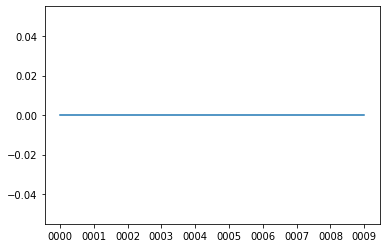

In [51]:
import matplotlib.pylab as plt

newA = dict(sorted(score_per_code.items(), key=operator.itemgetter(1), reverse=True)[:10])

lists = sorted(newA.items())

x, y = zip(*lists)

plt.plot(x, y)
plt.show()

In [19]:
prefix = "Ben's zipcode is "
texts = []
for zip_code in zip_codes:
    texts.append(prefix+zip_code)
doc = nlp2(texts[0])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)

Ben PERSON
0000 AU_POST_CODE


In [20]:
docs = list(nlp2.pipe(texts, disable=['ner']))
beams = nlp2.entity.beam_parse(docs, beam_width=beam_width, beam_density=beam_density)

score_per_code = {}

for doc, beam in zip(docs, beams):
    entity_scores = defaultdict(float)
    for score, ents in nlp2.entity.moves.get_beam_parses(beam):
        for start, end, label in ents:
            entity_scores[(start, end, label)] += score
    print(doc)
    print(entity_scores[(4,5,'AU_POST_CODE')])
    print(doc[4])
    score_per_code[doc[4].text]=entity_scores[(4,5,'AU_POST_CODE')]

Ben's zipcode is 0000
0.9851114794563316
0000
Ben's zipcode is 0001
0.9855027713316823
0001
Ben's zipcode is 0002
0.9851248439631787
0002
Ben's zipcode is 0003
0.9821396826913372
0003
Ben's zipcode is 0004
0.9851120306398743
0004
Ben's zipcode is 0005
0.9851161279893106
0005
Ben's zipcode is 0006
0.9851172119235201
0006
Ben's zipcode is 0007
0.9851192975823675
0007
Ben's zipcode is 0008
0.9851202559744163
0008
Ben's zipcode is 0009
0.9851088187599875
0009
Ben's zipcode is 0010
0.9851141038937147
0010
Ben's zipcode is 0011
0.9851162150837816
0011
Ben's zipcode is 0012
0.9851138290800795
0012
Ben's zipcode is 0013
0.9851044051985567
0013
Ben's zipcode is 0014
0.9844426641972087
0014
Ben's zipcode is 0015
0.9851157160966664
0015
Ben's zipcode is 0016
0.9851195564392499
0016
Ben's zipcode is 0017
0.9851003803291405
0017
Ben's zipcode is 0018
0.985121064544046
0018
Ben's zipcode is 0019
0.9851163936684366
0019
Ben's zipcode is 0020
0.9830157524306901
0020
Ben's zipcode is 0021
0.98301037293

Ben's zipcode is 0583
0.985111863436263
0583
Ben's zipcode is 0584
0.985116447529638
0584
Ben's zipcode is 0585
0.9808332984174271
0585
Ben's zipcode is 0586
0.9851278781490289
0586
Ben's zipcode is 0587
0.9851067923487056
0587
Ben's zipcode is 0588
0.9851123685944742
0588
Ben's zipcode is 0589
0.9809164566770735
0589
Ben's zipcode is 0590
0.9851176788481806
0590
Ben's zipcode is 0591
0.9851186078979273
0591
Ben's zipcode is 0592
0.9886682604530377
0592
Ben's zipcode is 0593
0.9851175840270676
0593
Ben's zipcode is 0594
0.9851180368073553
0594
Ben's zipcode is 0595
0.9851097650327069
0595
Ben's zipcode is 0596
0.9851164936710615
0596
Ben's zipcode is 0597
0.9851153303084546
0597
Ben's zipcode is 0598
0.9851220748910159
0598
Ben's zipcode is 0599
0.9851165233328807
0599
Ben's zipcode is 0600
0.9851130706681822
0600
Ben's zipcode is 0601
0.9851163790268828
0601
Ben's zipcode is 0602
0.9851181226233997
0602
Ben's zipcode is 0603
0.9851052169457084
0603
Ben's zipcode is 0604
0.985118599672

1082
Ben's zipcode is 1083
0.9851126896121003
1083
Ben's zipcode is 1084
0.9851201986711265
1084
Ben's zipcode is 1085
0.9851247054547199
1085
Ben's zipcode is 1086
0.9851159861866184
1086
Ben's zipcode is 1087
0.9851117306114812
1087
Ben's zipcode is 1088
0.9851209517718773
1088
Ben's zipcode is 1089
0.9851138226694963
1089
Ben's zipcode is 1090
0.9851229812987019
1090
Ben's zipcode is 1091
0.9851282857481047
1091
Ben's zipcode is 1092
0.9851125653795564
1092
Ben's zipcode is 1093
0.9851178733342986
1093
Ben's zipcode is 1094
0.9851136441277085
1094
Ben's zipcode is 1095
0.9851184215544484
1095
Ben's zipcode is 1096
0.9851168641091202
1096
Ben's zipcode is 1097
0.9851249139936771
1097
Ben's zipcode is 1098
0.985122971892595
1098
Ben's zipcode is 1099
0.9851282545328556
1099
Ben's zipcode is 1100
0.98511296661166
1100
Ben's zipcode is 1101
0.9851179411097711
1101
Ben's zipcode is 1102
0.9851185369387991
1102
Ben's zipcode is 1103
0.9814922517620004
1103
Ben's zipcode is 1104
0.98514028

1582
Ben's zipcode is 1583
0.9851161821767872
1583
Ben's zipcode is 1584
0.9851153491587156
1584
Ben's zipcode is 1585
0.9808312911623932
1585
Ben's zipcode is 1586
0.9851165040193564
1586
Ben's zipcode is 1587
0.9851207993714731
1587
Ben's zipcode is 1588
0.98513068715491
1588
Ben's zipcode is 1589
0.9809220546051541
1589
Ben's zipcode is 1590
0.98511363988244
1590
Ben's zipcode is 1591
0.9801595701966855
1591
Ben's zipcode is 1592
0.9851179370131878
1592
Ben's zipcode is 1593
0.9851200225658211
1593
Ben's zipcode is 1594
0.9851195684672088
1594
Ben's zipcode is 1595
0.9851283851798576
1595
Ben's zipcode is 1596
0.9851270487547865
1596
Ben's zipcode is 1597
0.9851169843883055
1597
Ben's zipcode is 1598
0.9851141411355375
1598
Ben's zipcode is 1599
0.9851117294779177
1599
Ben's zipcode is 1600
0.9851129420802847
1600
Ben's zipcode is 1601
0.9851177669376326
1601
Ben's zipcode is 1602
0.9851196135432834
1602
Ben's zipcode is 1603
0.9851217492714367
1603
Ben's zipcode is 1604
0.985108169

0.9862138563225655
2082
Ben's zipcode is 2083
0.9862104133313221
2083
Ben's zipcode is 2084
0.986210632644097
2084
Ben's zipcode is 2085
0.9862089300609569
2085
Ben's zipcode is 2086
0.9862132869269081
2086
Ben's zipcode is 2087
0.9862016488244081
2087
Ben's zipcode is 2088
0.9862081875519494
2088
Ben's zipcode is 2089
0.986212387121376
2089
Ben's zipcode is 2090
0.986213337841404
2090
Ben's zipcode is 2091
0.9862130825834655
2091
Ben's zipcode is 2092
0.9862171738888263
2092
Ben's zipcode is 2093
0.9862115644859648
2093
Ben's zipcode is 2094
0.9862114397647473
2094
Ben's zipcode is 2095
0.9862136107470648
2095
Ben's zipcode is 2096
0.9862079644938745
2096
Ben's zipcode is 2097
0.986212745406776
2097
Ben's zipcode is 2098
0.9862129548663907
2098
Ben's zipcode is 2099
0.9861816656737357
2099
Ben's zipcode is 2100
0.9862132626496894
2100
Ben's zipcode is 2101
0.9862120680318097
2101
Ben's zipcode is 2102
0.9862180204022415
2102
Ben's zipcode is 2103
0.9853795233670378
2103
Ben's zipcode 

0.98621309393573
2582
Ben's zipcode is 2583
0.9862114528134596
2583
Ben's zipcode is 2584
0.9862097164990773
2584
Ben's zipcode is 2585
0.9821426486575742
2585
Ben's zipcode is 2586
0.9862123674914589
2586
Ben's zipcode is 2587
0.9862118166730112
2587
Ben's zipcode is 2588
0.9862096617268719
2588
Ben's zipcode is 2589
0.9854967493347984
2589
Ben's zipcode is 2590
0.9862152374596757
2590
Ben's zipcode is 2591
0.9853863747066371
2591
Ben's zipcode is 2592
0.9862156638239816
2592
Ben's zipcode is 2593
0.9862159921515405
2593
Ben's zipcode is 2594
0.9862314140826487
2594
Ben's zipcode is 2595
0.9862115951906633
2595
Ben's zipcode is 2596
0.9862142391494757
2596
Ben's zipcode is 2597
0.9862193043719362
2597
Ben's zipcode is 2598
0.9840270242845279
2598
Ben's zipcode is 2599
0.9862187749165183
2599
Ben's zipcode is 2600
0.9862122813503266
2600
Ben's zipcode is 2601
0.9844954333320056
2601
Ben's zipcode is 2602
0.9862103157385149
2602
Ben's zipcode is 2603
0.9862136458787925
2603
Ben's zipcod

Ben's zipcode is 3082
0.9851176066341772
3082
Ben's zipcode is 3083
0.9851256154838515
3083
Ben's zipcode is 3084
0.9851110137548494
3084
Ben's zipcode is 3085
0.9851134669253665
3085
Ben's zipcode is 3086
0.9851177065755522
3086
Ben's zipcode is 3087
0.9851133068816867
3087
Ben's zipcode is 3088
0.9851166278287954
3088
Ben's zipcode is 3089
0.9851108658961014
3089
Ben's zipcode is 3090
0.9851182443841833
3090
Ben's zipcode is 3091
0.9851190069592186
3091
Ben's zipcode is 3092
0.9851121114112865
3092
Ben's zipcode is 3093
0.9851136473723466
3093
Ben's zipcode is 3094
0.9851096708233817
3094
Ben's zipcode is 3095
0.9851168009075517
3095
Ben's zipcode is 3096
0.9851140617636689
3096
Ben's zipcode is 3097
0.9851211554657794
3097
Ben's zipcode is 3098
0.985112222380113
3098
Ben's zipcode is 3099
0.9851208138144989
3099
Ben's zipcode is 3100
0.9851194195808973
3100
Ben's zipcode is 3101
0.9851184406726479
3101
Ben's zipcode is 3102
0.9851177335783659
3102
Ben's zipcode is 3103
0.98151732691

Ben's zipcode is 3582
0.9851192547184547
3582
Ben's zipcode is 3583
0.9851130282094401
3583
Ben's zipcode is 3584
0.9851194264907184
3584
Ben's zipcode is 3585
0.9808303391315845
3585
Ben's zipcode is 3586
0.985114351237571
3586
Ben's zipcode is 3587
0.9851177108196053
3587
Ben's zipcode is 3588
0.9851146211508774
3588
Ben's zipcode is 3589
0.9809115679605056
3589
Ben's zipcode is 3590
0.9851234224810965
3590
Ben's zipcode is 3591
0.9855822020612639
3591
Ben's zipcode is 3592
0.9851147552525629
3592
Ben's zipcode is 3593
0.985115438365281
3593
Ben's zipcode is 3594
0.9851124921457662
3594
Ben's zipcode is 3595
0.9794471115424327
3595
Ben's zipcode is 3596
0.9851106029475318
3596
Ben's zipcode is 3597
0.9851120561135036
3597
Ben's zipcode is 3598
0.9844393055355094
3598
Ben's zipcode is 3599
0.9851114888008378
3599
Ben's zipcode is 3600
0.9851181738495408
3600
Ben's zipcode is 3601
0.9851233431911821
3601
Ben's zipcode is 3602
0.9803764172891543
3602
Ben's zipcode is 3603
0.985114805334

4081
Ben's zipcode is 4082
0.985118929056264
4082
Ben's zipcode is 4083
0.9851235691381248
4083
Ben's zipcode is 4084
0.9851138818658037
4084
Ben's zipcode is 4085
0.9851154796852113
4085
Ben's zipcode is 4086
0.985111237248672
4086
Ben's zipcode is 4087
0.9851166264605519
4087
Ben's zipcode is 4088
0.9798207247102556
4088
Ben's zipcode is 4089
0.9758426267237881
4089
Ben's zipcode is 4090
0.9851056195529162
4090
Ben's zipcode is 4091
0.9851129132175498
4091
Ben's zipcode is 4092
0.985114499831087
4092
Ben's zipcode is 4093
0.9851150221010407
4093
Ben's zipcode is 4094
0.9851117263613438
4094
Ben's zipcode is 4095
0.9851140184543321
4095
Ben's zipcode is 4096
0.9851230766016053
4096
Ben's zipcode is 4097
0.9851240916091791
4097
Ben's zipcode is 4098
0.985115415842377
4098
Ben's zipcode is 4099
0.9851172023002879
4099
Ben's zipcode is 4100
0.9851200159218487
4100
Ben's zipcode is 4101
0.9851186098942684
4101
Ben's zipcode is 4102
0.985119729404028
4102
Ben's zipcode is 4103
0.9815092566

4581
Ben's zipcode is 4582
0.9851139174767716
4582
Ben's zipcode is 4583
0.985108636084388
4583
Ben's zipcode is 4584
0.9844382112890085
4584
Ben's zipcode is 4585
0.9808263369864506
4585
Ben's zipcode is 4586
0.9851647233255416
4586
Ben's zipcode is 4587
0.9851114383260177
4587
Ben's zipcode is 4588
0.9851204340199607
4588
Ben's zipcode is 4589
0.9809201932262456
4589
Ben's zipcode is 4590
0.9851147119197528
4590
Ben's zipcode is 4591
0.985118839006096
4591
Ben's zipcode is 4592
0.985121308072533
4592
Ben's zipcode is 4593
0.9851131020473366
4593
Ben's zipcode is 4594
0.9851217140491382
4594
Ben's zipcode is 4595
0.9851176504003462
4595
Ben's zipcode is 4596
0.9851160968235482
4596
Ben's zipcode is 4597
0.9851213911580111
4597
Ben's zipcode is 4598
0.9851011786263465
4598
Ben's zipcode is 4599
0.9851218813611657
4599
Ben's zipcode is 4600
0.9851155396907995
4600
Ben's zipcode is 4601
0.98508503489617
4601
Ben's zipcode is 4602
0.9851148176513517
4602
Ben's zipcode is 4603
0.9851182860

0.9862884965725389
5081
Ben's zipcode is 5082
0.9862901741374351
5082
Ben's zipcode is 5083
0.9862873667608009
5083
Ben's zipcode is 5084
0.9862873454526213
5084
Ben's zipcode is 5085
0.9862868611474307
5085
Ben's zipcode is 5086
0.9862891922979016
5086
Ben's zipcode is 5087
0.9862948813408049
5087
Ben's zipcode is 5088
0.9862918444660695
5088
Ben's zipcode is 5089
0.9862866277708907
5089
Ben's zipcode is 5090
0.9862866731041574
5090
Ben's zipcode is 5091
0.9862899551751232
5091
Ben's zipcode is 5092
0.9862866094021863
5092
Ben's zipcode is 5093
0.986282370658682
5093
Ben's zipcode is 5094
0.9862732013441186
5094
Ben's zipcode is 5095
0.9862933579026312
5095
Ben's zipcode is 5096
0.9863030645333137
5096
Ben's zipcode is 5097
0.9862879044555788
5097
Ben's zipcode is 5098
0.9862893070799451
5098
Ben's zipcode is 5099
0.9862876861395908
5099
Ben's zipcode is 5100
0.9862887739229628
5100
Ben's zipcode is 5101
0.9862881054840559
5101
Ben's zipcode is 5102
0.9862779051179557
5102
Ben's zipco

0.9862731303105009
5581
Ben's zipcode is 5582
0.9862913965096608
5582
Ben's zipcode is 5583
0.9862882093562059
5583
Ben's zipcode is 5584
0.9862870704398541
5584
Ben's zipcode is 5585
0.9820477556393478
5585
Ben's zipcode is 5586
0.9862899263448928
5586
Ben's zipcode is 5587
0.9862876582483082
5587
Ben's zipcode is 5588
0.986285484212026
5588
Ben's zipcode is 5589
0.9843943371555216
5589
Ben's zipcode is 5590
0.9862883465272857
5590
Ben's zipcode is 5591
0.9862897806105376
5591
Ben's zipcode is 5592
0.986286739376859
5592
Ben's zipcode is 5593
0.9862910843490473
5593
Ben's zipcode is 5594
0.9862927787000966
5594
Ben's zipcode is 5595
0.9862843035163954
5595
Ben's zipcode is 5596
0.9862863666395152
5596
Ben's zipcode is 5597
0.9862972148094109
5597
Ben's zipcode is 5598
0.9862862240585213
5598
Ben's zipcode is 5599
0.9840150368893985
5599
Ben's zipcode is 5600
0.9862798447280532
5600
Ben's zipcode is 5601
0.9862860628086216
5601
Ben's zipcode is 5602
0.9862823491053293
5602
Ben's zipcod

Ben's zipcode is 6081
0.9851178473466384
6081
Ben's zipcode is 6082
0.9851135660722238
6082
Ben's zipcode is 6083
0.9851218284657905
6083
Ben's zipcode is 6084
0.9851281009625927
6084
Ben's zipcode is 6085
0.9851315104834674
6085
Ben's zipcode is 6086
0.9850889082525812
6086
Ben's zipcode is 6087
0.985120218352905
6087
Ben's zipcode is 6088
0.9851162174929452
6088
Ben's zipcode is 6089
0.9851159730002349
6089
Ben's zipcode is 6090
0.9851177194765317
6090
Ben's zipcode is 6091
0.985115699319563
6091
Ben's zipcode is 6092
0.9851108474896735
6092
Ben's zipcode is 6093
0.9851148991933351
6093
Ben's zipcode is 6094
0.9851174018941219
6094
Ben's zipcode is 6095
0.9851154487639395
6095
Ben's zipcode is 6096
0.9851164380105891
6096
Ben's zipcode is 6097
0.9851169834548877
6097
Ben's zipcode is 6098
0.9851268466682395
6098
Ben's zipcode is 6099
0.9851149500321043
6099
Ben's zipcode is 6100
0.9851277567034515
6100
Ben's zipcode is 6101
0.9851227376948266
6101
Ben's zipcode is 6102
0.985126151384

Ben's zipcode is 6581
0.9851176911514408
6581
Ben's zipcode is 6582
0.9851174839183744
6582
Ben's zipcode is 6583
0.9851241227025032
6583
Ben's zipcode is 6584
0.9851125890882317
6584
Ben's zipcode is 6585
0.9808292541127659
6585
Ben's zipcode is 6586
0.9801389554076849
6586
Ben's zipcode is 6587
0.9851199387807336
6587
Ben's zipcode is 6588
0.9851116134747755
6588
Ben's zipcode is 6589
0.9808970518754359
6589
Ben's zipcode is 6590
0.9851213405751051
6590
Ben's zipcode is 6591
0.9851244118730577
6591
Ben's zipcode is 6592
0.9851133081996599
6592
Ben's zipcode is 6593
0.9851008580008391
6593
Ben's zipcode is 6594
0.9851121488344772
6594
Ben's zipcode is 6595
0.985129576644544
6595
Ben's zipcode is 6596
0.9844694371411058
6596
Ben's zipcode is 6597
0.9851181764266537
6597
Ben's zipcode is 6598
0.9851177223098408
6598
Ben's zipcode is 6599
0.9851252326284696
6599
Ben's zipcode is 6600
0.9795233897499204
6600
Ben's zipcode is 6601
0.9851068269888003
6601
Ben's zipcode is 6602
0.98511806922

7080
Ben's zipcode is 7081
0.9851188109671113
7081
Ben's zipcode is 7082
0.9851092471587327
7082
Ben's zipcode is 7083
0.9851236550262675
7083
Ben's zipcode is 7084
0.9851205953573571
7084
Ben's zipcode is 7085
0.9851176317401603
7085
Ben's zipcode is 7086
0.9851137614456704
7086
Ben's zipcode is 7087
0.985122106313835
7087
Ben's zipcode is 7088
0.9851204792954122
7088
Ben's zipcode is 7089
0.9851136160572785
7089
Ben's zipcode is 7090
0.9851141277989044
7090
Ben's zipcode is 7091
0.9851167055080102
7091
Ben's zipcode is 7092
0.9851165862356751
7092
Ben's zipcode is 7093
0.9851137153580559
7093
Ben's zipcode is 7094
0.9851187687553985
7094
Ben's zipcode is 7095
0.9831335479124993
7095
Ben's zipcode is 7096
0.9851187431921538
7096
Ben's zipcode is 7097
0.9851222044789675
7097
Ben's zipcode is 7098
0.9851154163481216
7098
Ben's zipcode is 7099
0.9851200205215114
7099
Ben's zipcode is 7100
0.9851280793501578
7100
Ben's zipcode is 7101
0.9851153330753816
7101
Ben's zipcode is 7102
0.985117

7580
Ben's zipcode is 7581
0.9852622466123192
7581
Ben's zipcode is 7582
0.9851174633794997
7582
Ben's zipcode is 7583
0.9851122854510606
7583
Ben's zipcode is 7584
0.985113697335369
7584
Ben's zipcode is 7585
0.9808282524002874
7585
Ben's zipcode is 7586
0.9851135216803841
7586
Ben's zipcode is 7587
0.9851169580495858
7587
Ben's zipcode is 7588
0.9851149070967503
7588
Ben's zipcode is 7589
0.9809247697836458
7589
Ben's zipcode is 7590
0.9851134166640737
7590
Ben's zipcode is 7591
0.9797402437019934
7591
Ben's zipcode is 7592
0.9851163674064999
7592
Ben's zipcode is 7593
0.985116526089714
7593
Ben's zipcode is 7594
0.985116731417985
7594
Ben's zipcode is 7595
0.9851161753621801
7595
Ben's zipcode is 7596
0.9851163009122025
7596
Ben's zipcode is 7597
0.9851182096232033
7597
Ben's zipcode is 7598
0.9851239171647198
7598
Ben's zipcode is 7599
0.9851170713909836
7599
Ben's zipcode is 7600
0.9851186348873728
7600
Ben's zipcode is 7601
0.9851179035034747
7601
Ben's zipcode is 7602
0.98511106

0.9851221295506217
8080
Ben's zipcode is 8081
0.985110462028725
8081
Ben's zipcode is 8082
0.9742589737683869
8082
Ben's zipcode is 8083
0.9851208084599506
8083
Ben's zipcode is 8084
0.9851172693133363
8084
Ben's zipcode is 8085
0.9851188674792395
8085
Ben's zipcode is 8086
0.9851159119487004
8086
Ben's zipcode is 8087
0.9851279296064321
8087
Ben's zipcode is 8088
0.9851189871909474
8088
Ben's zipcode is 8089
0.9851197762875767
8089
Ben's zipcode is 8090
0.9851169250763402
8090
Ben's zipcode is 8091
0.9851182976996206
8091
Ben's zipcode is 8092
0.9851165701106107
8092
Ben's zipcode is 8093
0.9851187872096593
8093
Ben's zipcode is 8094
0.9851086410737677
8094
Ben's zipcode is 8095
0.9798224968646351
8095
Ben's zipcode is 8096
0.9851128196348478
8096
Ben's zipcode is 8097
0.9851141245281443
8097
Ben's zipcode is 8098
0.9851190542580862
8098
Ben's zipcode is 8099
0.98511594194635
8099
Ben's zipcode is 8100
0.9851168841937669
8100
Ben's zipcode is 8101
0.9851161108110472
8101
Ben's zipcode

0.9851237508636324
8580
Ben's zipcode is 8581
0.9851318447443681
8581
Ben's zipcode is 8582
0.985118753578601
8582
Ben's zipcode is 8583
0.9851163914008029
8583
Ben's zipcode is 8584
0.9798187718934606
8584
Ben's zipcode is 8585
0.9808312832877941
8585
Ben's zipcode is 8586
0.9851155578112178
8586
Ben's zipcode is 8587
0.9851122720705345
8587
Ben's zipcode is 8588
0.9851161128745037
8588
Ben's zipcode is 8589
0.980967970895527
8589
Ben's zipcode is 8590
0.9851239524365932
8590
Ben's zipcode is 8591
0.9851179474673565
8591
Ben's zipcode is 8592
0.9851160262324187
8592
Ben's zipcode is 8593
0.9851173466860532
8593
Ben's zipcode is 8594
0.9851180635412046
8594
Ben's zipcode is 8595
0.9851511318716226
8595
Ben's zipcode is 8596
0.9851257762904572
8596
Ben's zipcode is 8597
0.9851245223063045
8597
Ben's zipcode is 8598
0.985116614134578
8598
Ben's zipcode is 8599
0.9851165058302416
8599
Ben's zipcode is 8600
0.9851209356417249
8600
Ben's zipcode is 8601
0.9851240450519921
8601
Ben's zipcode

Ben's zipcode is 9080
0.985116555542749
9080
Ben's zipcode is 9081
0.9797314131620086
9081
Ben's zipcode is 9082
0.985115521013013
9082
Ben's zipcode is 9083
0.985122980184013
9083
Ben's zipcode is 9084
0.9851139021039351
9084
Ben's zipcode is 9085
0.9851136830139645
9085
Ben's zipcode is 9086
0.9851187439836145
9086
Ben's zipcode is 9087
0.986135501818017
9087
Ben's zipcode is 9088
0.9851077390764185
9088
Ben's zipcode is 9089
0.9851147054466697
9089
Ben's zipcode is 9090
0.9851182635719262
9090
Ben's zipcode is 9091
0.985117620644246
9091
Ben's zipcode is 9092
0.9851055062075783
9092
Ben's zipcode is 9093
0.9851106810690254
9093
Ben's zipcode is 9094
0.9851117437787698
9094
Ben's zipcode is 9095
0.9851202760795204
9095
Ben's zipcode is 9096
0.9851227648436807
9096
Ben's zipcode is 9097
0.9851190864881129
9097
Ben's zipcode is 9098
0.9851198620695486
9098
Ben's zipcode is 9099
0.9850841367555485
9099
Ben's zipcode is 9100
0.9851132872114646
9100
Ben's zipcode is 9101
0.985113818635086

Ben's zipcode is 9580
0.9851143011869476
9580
Ben's zipcode is 9581
0.985105160848176
9581
Ben's zipcode is 9582
0.9851162903226091
9582
Ben's zipcode is 9583
0.9851046987919395
9583
Ben's zipcode is 9584
0.98511631479148
9584
Ben's zipcode is 9585
0.980833222964909
9585
Ben's zipcode is 9586
0.9851154757545955
9586
Ben's zipcode is 9587
0.9851272134929713
9587
Ben's zipcode is 9588
0.985115856469681
9588
Ben's zipcode is 9589
0.9809213885316171
9589
Ben's zipcode is 9590
0.9851171449953456
9590
Ben's zipcode is 9591
0.9851233244938896
9591
Ben's zipcode is 9592
0.985117018026528
9592
Ben's zipcode is 9593
0.9851158013470809
9593
Ben's zipcode is 9594
0.9851182282401024
9594
Ben's zipcode is 9595
0.9851163761356793
9595
Ben's zipcode is 9596
0.9851248912957814
9596
Ben's zipcode is 9597
0.9851183173731338
9597
Ben's zipcode is 9598
0.9851155150071222
9598
Ben's zipcode is 9599
0.9851168225448398
9599
Ben's zipcode is 9600
0.985115299717316
9600
Ben's zipcode is 9601
0.9851185390311128


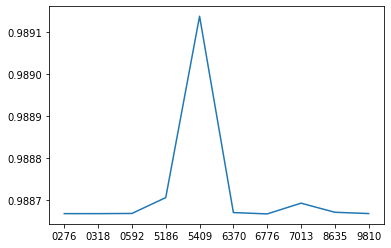

In [21]:
import matplotlib.pylab as plt

plt.figure()

newA = dict(sorted(score_per_code.items(), key=operator.itemgetter(1), reverse=True)[:10])

lists = sorted(newA.items())

x, y = zip(*lists)

plt.plot(x, y)
plt.show()

In [32]:
texts = ["Rana's password is qwertyui", "Rana's password is qwertyui", "Ben's password is 1234qwerty", "Rana's password is 1234qwerty", "Ben's password is qwertyui"]
    
for ent in nlp2(texts[0]).ents:
    print(ent.text, ent.label_)

docs = list(nlp2.pipe(texts, disable=['ner']))
beams = nlp2.entity.beam_parse(docs, beam_width=beam_width, beam_density=beam_density)

score_per_code = {}

for doc, beam in zip(docs, beams):
    entity_scores = defaultdict(float)
    for score, ents in nlp2.entity.moves.get_beam_parses(beam):
        for start, end, label in ents:
            entity_scores[(start, end, label)] += score
    #print(doc)
    print(entity_scores)
    score_per_code[doc.text]=entity_scores[(4, 5, 'PASSWORD')]

Rana PERSON
qwertyui PASSWORD
defaultdict(<class 'float'>, {(0, 1, 'PERSON'): 0.9999999999999998, (4, 5, 'PASSWORD'): 0.9870538398751009, (4, 5, 'AU_POST_CODE'): 0.005628037483083563, (1, 3, 'AU_POST_CODE'): 0.0006343950808887044, (1, 3, 'PASSWORD'): 0.0006343950808887044, (1, 2, 'AU_POST_CODE'): 0.0005525867269313339, (1, 2, 'PASSWORD'): 0.00035420837017243026, (2, 4, 'PASSWORD'): 0.00032323830654754933, (2, 4, 'AU_POST_CODE'): 0.00032323830654754933, (2, 3, 'PASSWORD'): 0.00016571073513972317, (4, 5, 'NORP'): 0.00016212696641308683, (3, 5, 'AU_POST_CODE'): 0.00015728787480225696, (3, 5, 'PASSWORD'): 0.00015728787480225696, (3, 4, 'AU_POST_CODE'): 0.00015146754062674334, (4, 5, 'GPE'): 0.00013950144745723624})
defaultdict(<class 'float'>, {(0, 1, 'PERSON'): 0.9999999999999998, (4, 5, 'PASSWORD'): 0.9870538398751009, (4, 5, 'AU_POST_CODE'): 0.005628037483083563, (1, 3, 'AU_POST_CODE'): 0.0006343950808887044, (1, 3, 'PASSWORD'): 0.0006343950808887044, (1, 2, 'AU_POST_CODE'): 0.000552586

In [33]:
score_per_code

{"Rana's password is qwertyui": 0.9870538398751009,
 "Ben's password is 1234qwerty": 0.8960463081987889,
 "Rana's password is 1234qwerty": 0.856450666997111,
 "Ben's password is qwertyui": 0.989948223018752}

In [66]:
alphabets = list(string.ascii_lowercase)

list(permutations(alphabets,2))

permutation = [p for p in itertools.product(alphabets, repeat=2)]

In [69]:
for i in permutation:
    print(''.join(i))

aa
ab
ac
ad
ae
af
ag
ah
ai
aj
ak
al
am
an
ao
ap
aq
ar
as
at
au
av
aw
ax
ay
az
ba
bb
bc
bd
be
bf
bg
bh
bi
bj
bk
bl
bm
bn
bo
bp
bq
br
bs
bt
bu
bv
bw
bx
by
bz
ca
cb
cc
cd
ce
cf
cg
ch
ci
cj
ck
cl
cm
cn
co
cp
cq
cr
cs
ct
cu
cv
cw
cx
cy
cz
da
db
dc
dd
de
df
dg
dh
di
dj
dk
dl
dm
dn
do
dp
dq
dr
ds
dt
du
dv
dw
dx
dy
dz
ea
eb
ec
ed
ee
ef
eg
eh
ei
ej
ek
el
em
en
eo
ep
eq
er
es
et
eu
ev
ew
ex
ey
ez
fa
fb
fc
fd
fe
ff
fg
fh
fi
fj
fk
fl
fm
fn
fo
fp
fq
fr
fs
ft
fu
fv
fw
fx
fy
fz
ga
gb
gc
gd
ge
gf
gg
gh
gi
gj
gk
gl
gm
gn
go
gp
gq
gr
gs
gt
gu
gv
gw
gx
gy
gz
ha
hb
hc
hd
he
hf
hg
hh
hi
hj
hk
hl
hm
hn
ho
hp
hq
hr
hs
ht
hu
hv
hw
hx
hy
hz
ia
ib
ic
id
ie
if
ig
ih
ii
ij
ik
il
im
in
io
ip
iq
ir
is
it
iu
iv
iw
ix
iy
iz
ja
jb
jc
jd
je
jf
jg
jh
ji
jj
jk
jl
jm
jn
jo
jp
jq
jr
js
jt
ju
jv
jw
jx
jy
jz
ka
kb
kc
kd
ke
kf
kg
kh
ki
kj
kk
kl
km
kn
ko
kp
kq
kr
ks
kt
ku
kv
kw
kx
ky
kz
la
lb
lc
ld
le
lf
lg
lh
li
lj
lk
ll
lm
ln
lo
lp
lq
lr
ls
lt
lu
lv
lw
lx
ly
lz
ma
mb
mc
md
me
mf
mg
mh
mi
mj
mk
ml
mm
mn
mo
mp
mq
mr
ms
mt
mu
m

In [72]:
threshold = 0
ground_truth = "Rana's password is qwertyui"
prefix = "Rana's password is "
password_len = 8


combinations = 1
alphabets = list(string.ascii_lowercase)
permutation = [p for p in itertools.product(alphabets, repeat=combinations)]
    
while prefix != ground_truth:
    texts = []
    for suffix in permutation:
        texts.append(prefix+''.join(suffix))
        
    docs = list(nlp2.pipe(texts, disable=['ner']))
    beams = nlp2.entity.beam_parse(docs, beam_width=beam_width, beam_density=beam_density)

    score_per_code = {}

    for doc, beam in zip(docs, beams):
        entity_scores = defaultdict(float)
        for score, ents in nlp2.entity.moves.get_beam_parses(beam):
            for start, end, label in ents:
                entity_scores[(start, end, label)] += score
        score_per_code[doc.text]=entity_scores[(4, 5, 'PASSWORD')]
    #print(score_per_code)
    max_pref = max(score_per_code.items(), key=operator.itemgetter(1))[0]
    score = max(score_per_code.items(), key=operator.itemgetter(1))[1]
    
    if score > threshold:
        prefix = max_pref
        threshold = score
        permutation = [p for p in itertools.product(alphabets, repeat=1)]
        print(prefix)
    else:
        combinations += 1
        permutation = [p for p in itertools.product(alphabets, repeat=combinations)]

Rana's password is q
Rana's password is qif


KeyboardInterrupt: 